In [1]:
import json
import os
from glob import glob
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm_notebook as tqdm
import sys

In [2]:
txt_path = '/home/nikolay/workspace/mfo/data/total/00220-05001_0879f88b-245b-11e5-81f6-f01fafe92f9d/00220-05001.txt'
with open(txt_path) as json_file:
    data = json.load(json_file)
data

{'ЗаймНомер': 'Н0022005001',
 'ЗаймДата': '2020-01-22T11:56:21',
 'ПланДата': '2020-02-07T00:00:00',
 'ЗаймСумма': 1000,
 'РезультатНейросеть': '1',
 'МассивФото': ['2ae021d0-43f5-4c91-95f0-0f72eca1b07b',
  'e08312ed-c41c-4947-8179-88f2c492aea9',
  '1a1671e6-c701-4a0c-a20e-dd35126500f1',
  'cd0a759a-4658-4f51-9531-13dd726bd2a8',
  '79df150a-ee5d-48ea-ad39-816eb17eb554',
  'b888fe78-0972-4c50-96f1-1dce1d232edb',
  'c364a4e4-fef9-49da-9e37-9f4b26c08261',
  '13ac9b24-bce8-4c2e-bcab-2bfe92d25f15',
  '04aaa1e6-68ea-47f4-af8b-9f0d036117db',
  '965324a0-49fb-4608-9a66-cbbb549c21d0'],
 'Персона': {'ДатаРождения': '1983-06-23T00:00:00',
  'АдресРегистрацииИндекс': '443093',
  'АдресРегистрацииРегион': 'Самарская обл',
  'АдресРегистрацииРайон': '',
  'АдресРегистрацииГород': 'Самара г',
  'АдресРегистрацииНасПункт': '',
  'АдресРегистрацииУлица': 'Мориса Тореза ул',
  'АдресФактическогоПроживанияИндекс': '443093',
  'АдресФактическогоПроживанияРегион': 'Самарская обл',
  'АдресФактическогоПрожи

In [4]:
# '''### TXT PARSING
def parse_txt_in_folder(path):
    df = pd.DataFrame()
    df['loan_finished'] = None

    for folder_num, folder_name in enumerate(tqdm(os.listdir(path)[:])):

        folder_path = os.path.join(path, folder_name)
        i = [i for i in os.listdir(folder_path) if i.endswith('txt')]
        if len(i) == 0:
            continue
        txt_path = os.path.join(folder_path, i[0])
        try:
            with open(txt_path) as json_file:
                data = json.load(json_file)
        except:
            df.at[folder_num, 'folder_name'] = folder_name


        ### parse txt file
        trans_ids = data.keys()
        total_given    = 0
        loan_etap_list = []
        total_taken = 0 

        loan    = data
        history = loan['История']

        total_taken += loan['ЗаймСумма'] ### total_taken

        for key in history.keys():
            if key.startswith('Оплата'):
                total_given += history[key]['СуммаОД']
                total_given += history[key]['СуммаПроцент']

            if key.startswith('Увеличение'): 
                total_taken += history[key]['СуммаОД']

            if key.startswith('Закрытие'): 
                df.at[folder_num, 'loan_finished'] = 1
                total_given += history[key]['СуммаОД']
                total_given += history[key]['СуммаПроцент']
                loan_etap_list.append(history['Закрытие']['Этап'])

            if key.startswith('Пролонгация'):
                df.at[folder_num, 'prolong'] = 1

        person         = loan['Персона']
        date_of_birth  = person['ДатаРождения'][:10]
        adress_index   = person['АдресФактическогоПроживанияИндекс']
        adress_region  = person['АдресФактическогоПроживанияРегион']
        source         = person['ИсточникИнформации']
        childs         = person['КоличествоИждевенцев']
        education      = person['Образование']
        job            = person['ОрганизацияДолжность']
        gender         = person['Пол']
        marital_status = person['СемейноеСтатус']

        ### add data to df
#         df.at[folder_num, 'РезультатНейросеть'] = loan['РезультатНейросеть']
        df.at[folder_num, 'folder_name'] = folder_name
        df.at[folder_num, 'date_of_birth'] = date_of_birth
        df.at[folder_num, 'loan_date'] = loan['ЗаймДата'][:10]
        df.at[folder_num, 'loan_end_date'] = loan['ПланДата'][:10]
        df.at[folder_num, 'adress_index'] = adress_index
        df.at[folder_num, 'adress_region'] = adress_region
        df.at[folder_num, 'source'] = source
        df.at[folder_num, 'childs'] = childs
        df.at[folder_num, 'education'] = education
        df.at[folder_num, 'job'] = job
        df.at[folder_num, 'gender'] = gender
        df.at[folder_num, 'marital_status'] = marital_status
        df.at[folder_num, 'total_taken'] = total_taken
        df.at[folder_num, 'total_given'] = total_given
        df.at[folder_num, 'loan_etap_median'] = np.median(loan_etap_list)
        df.at[folder_num, 'loan_etap_max'] = (np.max(loan_etap_list) if len(loan_etap_list) > 0 else np.nan) 

    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], errors='coerce', format="%Y-%m-%d")
    df['loan_date'] = pd.to_datetime(df['loan_date'], errors='coerce', format="%Y-%m-%d")
    df['date_of_birth'].fillna(value=pd.to_datetime('1/1/1984'), inplace=True) 
    df['loan_finished'] = df['loan_finished'].fillna(0)
    df['prolong'] = df['prolong'].fillna(0)
    df['total_profit'] = df['total_given'] - df['total_taken']
    df['total_profit_percent'] = df['total_profit'] / df['total_taken']
    df['age'] = (df['loan_date'] - df['date_of_birth']).astype('<m8[Y]')
    # df = df.join(dff)
    # df = df[df['Верхнее веко'].isna()==False]

    return df

df = parse_txt_in_folder('../data/total')
df

/home/nikolay/anaconda3/envs/merlin/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,loan_finished,folder_name,date_of_birth,loan_date,loan_end_date,adress_index,adress_region,source,childs,education,...,gender,marital_status,total_taken,total_given,loan_etap_median,loan_etap_max,prolong,total_profit,total_profit_percent,age
0,1,39118-02-016_1c7ea7b8-30fd-11e5-81f6-f01fafe92f9d,1980-02-28,2018-01-11,2018-01-25,461034,Оренбургская обл,Звонок КС,3.0,Средне-специальное,...,Мужской,Гражданский брак,2000.0,2320.00,1.0,1.0,0.0,320.00,0.160000,37.0
1,1,04519-20010_dc1fb083-df28-11e7-80e7-000c293676f4,1962-09-08,2019-05-07,2019-05-21,446103,Самарская обл,Банер / Короб на офисе,0.0,среднее-техническое,...,Женский,Вдовец / Вдова,6000.0,12005.67,1.0,1.0,1.0,6005.67,1.000945,56.0
2,0,18-04-000018_9f0da275-01aa-11e8-80eb-000c293676f4,1977-11-03,2018-01-26,2018-02-09,461040,Оренбургская обл,Звонок с горячей линии,0.0,Среднее,...,Мужской,Гражданский брак,3000.0,0.00,NaN,NaN,0.0,-3000.00,-1.000000,40.0
3,1,19019-04-008_20534214-6d31-11e8-80f4-000c293676f4,1976-03-02,2019-01-22,2019-02-05,461363,Оренбургская обл,Наружная реклама,2.0,Средне-специальное,...,Мужской,Женат / Замужем,10000.0,12800.00,1.0,1.0,0.0,2800.00,0.280000,42.0
4,0,56318-19-021_25060137-84b6-11e7-80e6-000c293676f4,1977-05-12,2018-05-11,2018-05-25,446116,Самарская обл,Звонок КС,0.0,Среднее,...,Женский,Холост / Не замужем,10000.0,4200.00,NaN,NaN,1.0,-5800.00,-0.580000,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35174,1,54918-20-015_3cb8df22-5c16-11e8-80f3-000c293676f4,1978-09-13,2018-05-20,2018-06-03,446305,Самарская обл,Банер / Короб на офисе,1.0,Среднее,...,Женский,Вдовец / Вдова,2000.0,2320.00,1.0,1.0,0.0,320.00,0.160000,39.0
35175,1,04618-47-014_13b332b6-45e4-11e8-80f1-000c293676f4,1946-01-01,2018-11-24,2018-12-08,446253,Самарская обл,Банер / Короб на офисе,0.0,среднее-техническое,...,Женский,Вдовец / Вдова,3500.0,4095.00,1.0,1.0,1.0,595.00,0.170000,72.0
35176,1,37018-47-006_65da8683-d9a8-11e8-80ff-000c293676f4,1960-11-28,2018-11-20,2018-12-04,460034,Оренбургская обл,Наружная реклама,0.0,среднее-техническое,...,Мужской,Женат / Замужем,4000.0,5360.00,1.0,1.0,1.0,1360.00,0.340000,57.0
35177,1,13818-09-011_b8f7cd5d-1d0d-11e8-80eb-000c293676f4,1978-02-03,2018-03-01,2018-03-08,460508,Оренбургская обл,Интернет,1.0,Среднее,...,Женский,Разведен / Разведена,3000.0,3000.00,1.0,1.0,0.0,0.00,0.000000,40.0


In [5]:
df.to_pickle('../data/total.pkl')

<AxesSubplot:xlabel='loan_date', ylabel='Count'>

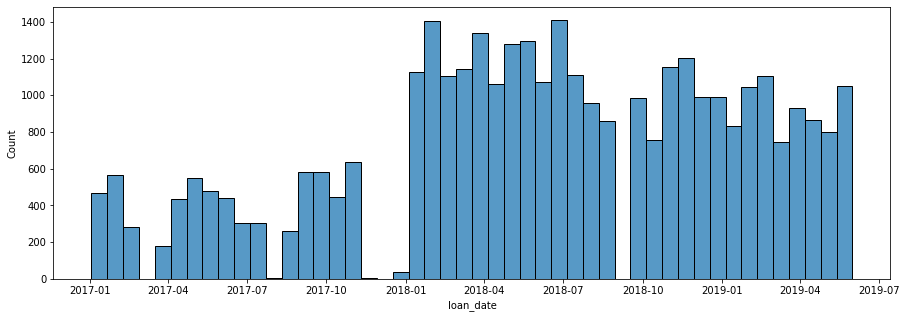

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
sns.histplot(data=df, x="loan_date")